In [82]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.autograd import Variable
import string
import pickle as pkl
import random
import pdb
import re
from functools import partial
from collections import Counter, defaultdict
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('punkt')
from gensim.models.keyedvectors import KeyedVectors
import matplotlib.pyplot as plt

RANDOM_STATE = 42

[nltk_data] Downloading package punkt to /home/tx443/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [67]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

### Get pre-trained embeddings

In [2]:
# encode the pretrained embedding to text file
model = KeyedVectors.load_word2vec_format('/home/hb1500/Plated/vocab.bin', binary=True)
model.save_word2vec_format('pretrained_embd.txt', binary=False)

In [3]:
# load embeddings
# There are three types of embeddings: 
# pretrained_embd (from Recipe101); pretrained_embd (Recipe101 + Plated); Glove.6B.50d
def load_emb_vectors(fname):
    data = {}
    with open(fname, 'r') as f:
        for line in f:
            splitLine = line.split()
            word = splitLine[0]
            embedding = np.array([float(val) for val in splitLine[1:]])
            data[word] = embedding
    return data
#fname = 'pretrained_embd.txt'
#fname = '/Users/hetianbai/Desktop/DS-GA 1011/Labs/lab5/glove.6B/glove.6B.50d.txt'
fname = '../../data/glove.6B.50d.txt'
words_emb_dict = load_emb_vectors(fname)

### Load Cleaned Data 

In [83]:
steps = ['step_one','step_two', 'step_three', 'step_four', 'step_five', 'step_six']
steps_aug = ['step_one_sp', 'step_two_sp', 'step_three_sp',
             'step_four_sp', 'step_five_sp', 'step_six_sp']
tags = ['tag_cuisine_indian', 'tag_cuisine_nordic', 'tag_cuisine_european',
        'tag_cuisine_asian', 'tag_cuisine_mexican',
        'tag_cuisine_latin-american', 'tag_cuisine_french',
        'tag_cuisine_italian', 'tag_cuisine_african',
        'tag_cuisine_mediterranean', 'tag_cuisine_american',
        'tag_cuisine_middle-eastern']

In [20]:
# # the data is the output of "Consolidated Data Cleaning"
# data_all = pd.read_csv('../../data/cleaned_recipe_data.csv', index_col=0)
# # augmentated data saved to: https://drive.google.com/open?id=10Y3wExYdavqalI17d7KBI2RdKjRu4UP3
# data_all_aug = pd.read_csv('../../data/augmented_instruction.csv', index_col=0)
# data_all_aug.set_index('external_id', inplace=True)
# #assert (data_all.index.values.tolist() == data_all_aug.index.values.tolist())

# data_all_aug = data_all_aug[steps_aug]
# data_with_aug = pd.merge(data_all, data_all_aug, how='outer', left_index=True, right_index=True)
# data_with_aug.to_csv('../data/recipe_data_with_aug.csv')

In [84]:
data_with_aug = pd.read_csv('../data/recipe_data_with_aug.csv', index_col=0)

In [85]:
data_with_aug_tags = data_with_aug[steps+steps_aug+tags]

In [86]:
print(data_with_aug_tags.columns)

Index(['step_one', 'step_two', 'step_three', 'step_four', 'step_five',
       'step_six', 'step_one_sp', 'step_two_sp', 'step_three_sp',
       'step_four_sp', 'step_five_sp', 'step_six_sp', 'tag_cuisine_indian',
       'tag_cuisine_nordic', 'tag_cuisine_european', 'tag_cuisine_asian',
       'tag_cuisine_mexican', 'tag_cuisine_latin-american',
       'tag_cuisine_french', 'tag_cuisine_italian', 'tag_cuisine_african',
       'tag_cuisine_mediterranean', 'tag_cuisine_american',
       'tag_cuisine_middle-eastern'],
      dtype='object')


### Tokenization

In [91]:
# lowercase and remove punctuation
def tokenizer(sent):
    #print(sent)
    if pd.isnull(sent):
        words = []
    else:
        table = str.maketrans(string.punctuation, ' '*len(string.punctuation))
        sent = sent.translate(table)
        tokens = word_tokenize(sent)
        # convert to lower case
        tokens = [w.lower() for w in tokens]
        # remove punctuation from each word
        #table = str.maketrans('', '', string.punctuation)
        #stripped = [w.translate(table) for w in tokens]
        # remove remaining tokens that are not alphabetic
        words = [word for word in tokens if word.isalpha()]
        #re.findall(r'\d+', 'sdfa')
    return words

In [89]:
def tokenize_dataset(step_n):
    """returns tokenization for each step, training set tokenizatoin"""
    token_dataset = []
    for sample in step_n:
        tokens = tokenizer(sample)
        token_dataset.append(tokens)
    return token_dataset

def all_tokens_list(train_data):
    """returns all tokens of instruction (all steps) for creating vocabulary"""
    all_tokens = []
    for columns in train_data.columns:
        for sample in train_data[columns]:
            all_tokens += sample[:] 
    return all_tokens

In [90]:
print('Processing original instruction data')
# tokenize each steps on original datasets
steps_token = []
for step in steps:
    steps_token.append(step+'_token')
    data_with_aug_tags[step+'_token'] = tokenize_dataset(data_with_aug_tags[step])
    print(step, 'has been tokenized.')

# tokenize each steps on augmented datasets
print('Processing augmented instruction data')
steps_aug_token = []
for step in steps_aug:
    steps_aug_token.append(step+'_token')
    data_with_aug_tags[step+'_token'] = tokenize_dataset(data_with_aug_tags[step])
    print(step, 'has been tokenized.')

Processing original instruction data
null
null
null
null


/home/tx443/pyenv/py3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


step_one has been tokenized.
null
null
null
null
step_two has been tokenized.
null
null
null
null
step_three has been tokenized.
null
null
null
null
null
null
step_four has been tokenized.
null
null
null
null
null
null
null
null
step_five has been tokenized.
null
null
null
null
null
null
null
null
null
null
null
null
null
null
null
null
null
null
null
null
null
null
null
null
null
null
null
null
null
null
null
null
step_six has been tokenized.
Processing augmented instruction data
null
null
null
null


/home/tx443/pyenv/py3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


step_one_sp has been tokenized.
null
null
null
null
step_two_sp has been tokenized.
null
null
null
null
step_three_sp has been tokenized.
null
null
null
null
null
null
step_four_sp has been tokenized.
null
null
null
null
null
null
null
null
step_five_sp has been tokenized.
null
null
null
null
null
null
null
null
null
null
null
null
null
null
null
null
null
null
null
null
null
null
null
null
null
null
null
null
null
null
null
null
step_six_sp has been tokenized.


In [92]:
data_with_aug_tags = data_with_aug_tags[steps_token+steps_aug_token+tags]

In [93]:
data_with_aug_tags.columns

Index(['step_one_token', 'step_two_token', 'step_three_token',
       'step_four_token', 'step_five_token', 'step_six_token',
       'step_one_sp_token', 'step_two_sp_token', 'step_three_sp_token',
       'step_four_sp_token', 'step_five_sp_token', 'step_six_sp_token',
       'tag_cuisine_indian', 'tag_cuisine_nordic', 'tag_cuisine_european',
       'tag_cuisine_asian', 'tag_cuisine_mexican',
       'tag_cuisine_latin-american', 'tag_cuisine_french',
       'tag_cuisine_italian', 'tag_cuisine_african',
       'tag_cuisine_mediterranean', 'tag_cuisine_american',
       'tag_cuisine_middle-eastern'],
      dtype='object')

Split train and test sets

In [95]:
train, test_data = train_test_split(data_with_aug_tags, test_size=0.1, random_state=RANDOM_STATE)
test_data = test_data[steps_token+tags]
#train_data, val_data, train_tags, val_tags = train_test_split(X_train, y_train, test_size=0.1, random_state=RANDOM_STATE)

In [106]:
aug2ori_colname = dict(zip(steps_aug_token+tags, steps_token+tags))

In [107]:
aug2ori_colname 

{'step_five_sp_token': 'step_five_token',
 'step_four_sp_token': 'step_four_token',
 'step_one_sp_token': 'step_one_token',
 'step_six_sp_token': 'step_six_token',
 'step_three_sp_token': 'step_three_token',
 'step_two_sp_token': 'step_two_token',
 'tag_cuisine_african': 'tag_cuisine_african',
 'tag_cuisine_american': 'tag_cuisine_american',
 'tag_cuisine_asian': 'tag_cuisine_asian',
 'tag_cuisine_european': 'tag_cuisine_european',
 'tag_cuisine_french': 'tag_cuisine_french',
 'tag_cuisine_indian': 'tag_cuisine_indian',
 'tag_cuisine_italian': 'tag_cuisine_italian',
 'tag_cuisine_latin-american': 'tag_cuisine_latin-american',
 'tag_cuisine_mediterranean': 'tag_cuisine_mediterranean',
 'tag_cuisine_mexican': 'tag_cuisine_mexican',
 'tag_cuisine_middle-eastern': 'tag_cuisine_middle-eastern',
 'tag_cuisine_nordic': 'tag_cuisine_nordic'}

Cross validation for train and validation 

In [120]:
rnn_types = {
    'rnn': nn.RNN,
    'lstm': nn.LSTM,
    'gru': nn.GRU
}

params = dict(
    rnn1_type = 'gru',
    rnn2_type = 'gru',
    bi = True,
    hidden_dim1 = 30,
    hidden_dim2 = 30,
    num_classes = 1,
    
    num_epochs = 5,
    batch_size = 50,
    learning_rate = 0.01,
    add_data_aug = True,
    cuda_on = True
)

In [121]:
kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
k = 1
predicted_tags = 'tag_cuisine_american' 
for train_index, val_index in kf.split(train):
    print('===================== This is the Kfold {} ====================='.format(k))
    k += 1
    val_data = train[steps_token+tags].iloc[val_index]
    train_data = train.iloc[train_index]
    #print(len(train_data), len(train_data.dropna()))
    
    if params['add_data_aug']:
        ##### add augmentation to training set by index #####
        train_org = train_data[steps_token+tags]
        train_aug = train_data[steps_aug_token+tags]
        train_aug.rename(index=str, columns=aug2ori_colname, inplace=True)
        # concatenate dfs
        train_data = pd.concat([train_org, train_aug], axis=0, ignore_index=False)
        ##### add augmentation to training set by index #####
    else:
        train_data = train_data[steps_token+tags]
    
    #print(len(train_data), len(train_data.dropna()))
    #look up
    train_targets = list(train_data[predicted_tags])
    val_targets = list(val_data[predicted_tags])
    test_targets = list(test_data[predicted_tags])
    
    train_X = train_data[steps_token]
    val_X = val_data[steps_token]
    test_X = test_data[steps_token]
    all_train_tokens = all_tokens_list(train_X)
    max_vocab_size = len(list(set(all_train_tokens)))
    token2id, id2token = build_vocab(all_train_tokens, max_vocab_size)
    emb_weight = build_emb_weight(words_emb_dict, id2token)
    train_data_indices = token2index_dataset(train_X, token2id)
    val_data_indices = token2index_dataset(val_X, token2id)
    test_data_indices = token2index_dataset(test_X, token2id)

    # batchify datasets: 
    batch_size = params['batch_size']
    max_sent_len = np.array([94, 86, 87, 90, 98, 91])
    train_loader, val_loader, test_loader = create_dataset_obj(train_data_indices, val_data_indices,
                                                           test_data_indices, train_targets,
                                                           val_targets, test_targets,
                                                           batch_size, max_sent_len, 
                                                           collate_func)
    
    model_train(params, emb_weight, train_loader, val_loader, test_loader)

===================== This is the Kfold 1 =====================


/share/apps/python3/3.6.3/intel/lib/python3.6/site-packages/pandas-0.22.0-py3.6-linux-x86_64.egg/pandas/core/frame.py:3027: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


The number of train parameters 23071
1/5, Step:1/73, TrainLoss:0.673671, ValAUC:0.516710 ValAcc:0.754425
1/5, Step:11/73, TrainLoss:0.512991, ValAUC:0.536419 ValAcc:0.754425
1/5, Step:21/73, TrainLoss:0.590027, ValAUC:0.531796 ValAcc:0.754425
1/5, Step:31/73, TrainLoss:0.628712, ValAUC:0.569258 ValAcc:0.754425
1/5, Step:41/73, TrainLoss:0.592697, ValAUC:0.609839 ValAcc:0.754425
1/5, Step:51/73, TrainLoss:0.601926, ValAUC:0.651291 ValAcc:0.754425
1/5, Step:61/73, TrainLoss:0.494686, ValAUC:0.675121 ValAcc:0.754425
1/5, Step:71/73, TrainLoss:0.570093, ValAUC:0.723865 ValAcc:0.751047
Epoch: [1/5], trainAUC: 0.773962, trainAcc: 0.678326
Epoch: [1/5], ValAUC: 0.730364, ValAcc: 0.720652
2/5, Step:1/73, TrainLoss:0.532694, ValAUC:0.738950 ValAcc:0.719526
2/5, Step:11/73, TrainLoss:0.564985, ValAUC:0.784127 ValAcc:0.681250
2/5, Step:21/73, TrainLoss:0.413808, ValAUC:0.803413 ValAcc:0.734161
2/5, Step:31/73, TrainLoss:0.509308, ValAUC:0.808909 ValAcc:0.691381
2/5, Step:41/73, TrainLoss:0.425131

3/5, Step:21/73, TrainLoss:0.325463, ValAUC:0.839920 ValAcc:0.623247
3/5, Step:31/73, TrainLoss:0.550491, ValAUC:0.851758 ValAcc:0.596551
3/5, Step:41/73, TrainLoss:0.403525, ValAUC:0.853704 ValAcc:0.614348
3/5, Step:51/73, TrainLoss:0.192399, ValAUC:0.862447 ValAcc:0.622357
3/5, Step:61/73, TrainLoss:0.259391, ValAUC:0.865213 ValAcc:0.591211
3/5, Step:71/73, TrainLoss:0.457422, ValAUC:0.864627 ValAcc:0.609899
Epoch: [3/5], trainAUC: 0.947369, trainAcc: 0.653880
Epoch: [3/5], ValAUC: 0.861627, ValAcc: 0.639264
4/5, Step:1/73, TrainLoss:0.163323, ValAUC:0.859095 ValAcc:0.645493
4/5, Step:11/73, TrainLoss:0.207560, ValAUC:0.841139 ValAcc:0.634815
4/5, Step:21/73, TrainLoss:0.343780, ValAUC:0.840436 ValAcc:0.635705
4/5, Step:31/73, TrainLoss:0.366606, ValAUC:0.852532 ValAcc:0.608119
4/5, Step:41/73, TrainLoss:0.310932, ValAUC:0.853422 ValAcc:0.584982
4/5, Step:51/73, TrainLoss:0.174066, ValAUC:0.865635 ValAcc:0.572524
4/5, Step:61/73, TrainLoss:0.318437, ValAUC:0.865752 ValAcc:0.593881
4/

5/5, Step:51/73, TrainLoss:0.144132, ValAUC:0.831804 ValAcc:0.634599
5/5, Step:61/73, TrainLoss:0.094019, ValAUC:0.834004 ValAcc:0.659800
5/5, Step:71/73, TrainLoss:0.055982, ValAUC:0.827003 ValAcc:0.656364
Epoch: [5/5], trainAUC: 0.993137, trainAcc: 0.603041
Epoch: [5/5], ValAUC: 0.825098, ValAcc: 0.657509


In [119]:
def model_train(params, emb_weight, train_loader, val_loader, test_loader):
    rnn1_type = params['rnn1_type'] 
    rnn_1 = rnn_types[rnn1_type]
    rnn2_type = params['rnn2_type']
    rnn_2 = rnn_types[rnn2_type]
    bi = params['bi']
    hidden_dim1 = params['hidden_dim1']
    hidden_dim2 = params['hidden_dim2']
    num_classes = params['num_classes']
    batch_size = params['batch_size']
    cuda_on = params['cuda_on']

    weights_matrix = torch.from_numpy(emb_weight)
    model = two_stage_RNN(rnn_1, hidden_dim1, bi, rnn_2, hidden_dim2, batch_size, 
                          cuda_on, weights_matrix, num_classes)
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    print('The number of train parameters', sum([np.prod(p.size()) for p in model_parameters]))
    model = model.to(device)

    #parameter for training
    learning_rate = params['learning_rate']
    num_epochs = params['num_epochs'] # number epoch to train

    # Criterion and Optimizer
    criterion = nn.BCEWithLogitsLoss() #torch.nn.BCELoss(); torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    train_loss_list = []
    train_AUC_list = []
    val_AUC_list = []
    train_ACC_list = []
    val_ACC_list = []
    for epoch in range(num_epochs):
        for i, (steps_batch, lengths_batch, labels_batch) in enumerate(train_loader):
            for step_id in range(6):
                lengths_batch[step_id] = lengths_batch[step_id].to(device)
                steps_batch[step_id] = steps_batch[step_id].to(device)
            model.train()
            optimizer.zero_grad()
            outputs = model(steps_batch, lengths_batch)
            loss = criterion(outputs, labels_batch.view(-1,1).float().to(device)) 
            train_loss_list.append(loss.item())
            loss.backward()
            optimizer.step()
            # validate every 10 iterations
            if i % 10 == 0:
                val_auc, val_acc = test_model(val_loader, model)
                print('{}/{}, Step:{}/{}, TrainLoss:{:.6f}, ValAUC:{:.6f} ValAcc:{:.6f}'.format(
                    epoch+1, num_epochs, i+1, len(train_loader), loss, val_auc, val_acc))
        val_auc, val_acc = test_model(val_loader, model)
        train_auc, train_acc = test_model(train_loader, model)
        train_AUC_list.append(train_auc)
        val_AUC_list.append(val_auc)
        train_ACC_list.append(train_acc)
        val_ACC_list.append(val_acc)
        print('Epoch: [{}/{}], trainAUC: {:.6f}, trainAcc: {:.6f}'.format(epoch+1, num_epochs, train_auc, train_acc))
        print('Epoch: [{}/{}], ValAUC: {:.6f}, ValAcc: {:.6f}'.format(epoch+1, num_epochs, val_auc, val_acc))
    return train_loss_list, train_AUC_list, val_AUC_list, train_ACC_list, val_ACC_list  

 All tokens from training set

In [25]:
# form all tokens list
all_train_tokens = all_tokens_list(train_data)

Let's decide which tag to predict for trail

In [23]:
data_cuisine_tags.iloc[:,1:].sum()/data_cuisine_tags.iloc[:,1:].shape[0]

tag_cuisine_indian            0.023525
tag_cuisine_nordic            0.000399
tag_cuisine_european          0.012360
tag_cuisine_asian             0.182217
tag_cuisine_mexican           0.013557
tag_cuisine_latin-american    0.094896
tag_cuisine_french            0.077352
tag_cuisine_italian           0.233254
tag_cuisine_african           0.003987
tag_cuisine_mediterranean     0.076555
tag_cuisine_american          0.273525
tag_cuisine_middle-eastern    0.046252
dtype: float64

Choose tag: tag_cuisine_american, which 27.3525% are 1 

### Build vocabulary and indexing 

In [26]:
len(list(set(all_train_tokens)))

3157

In [27]:
token_counter = Counter(all_train_tokens)
# token_counter.most_common

In [70]:
# save index 0 for unk and 1 for pad
def build_vocab(all_tokens, max_vocab_size):
    # Returns:
    # id2token: list of tokens, where id2token[i] returns token that corresponds to token i
    # token2id: dictionary where keys represent tokens and corresponding values represent indices
    PAD_IDX = 0
    UNK_IDX = 1
    token_counter = Counter(all_tokens)
    vocab, count = zip(*token_counter.most_common(max_vocab_size))
    id2token = list(vocab)
    token2id = dict(zip(vocab, range(2,2+len(vocab)))) 
    id2token = ['<pad>', '<unk>'] + id2token
    token2id['<pad>'] = PAD_IDX 
    token2id['<unk>'] = UNK_IDX
    return token2id, id2token

In [29]:
max_vocab_size = len(list(set(all_train_tokens)))
token2id, id2token = build_vocab(all_train_tokens, max_vocab_size)

random_token_id = random.randint(0, len(id2token)-1)
random_token = id2token[random_token_id]

print("Token id {} ; token {}".format(random_token_id, id2token[random_token_id]))
print("Token {}; token id {}".format(random_token, token2id[random_token]))

Token id 2614 ; token switch
Token switch; token id 2614


In [71]:
def build_emb_weight(words_emb_dict, id2token):
    vocab_size = len(id2token)
    emb_dim = len(words_emb_dict['a'])
    emb_weight = np.zeros([vocab_size, emb_dim])
    for i in range(2,vocab_size):
        emb = words_emb_dict.get(id2token[i], None)
        if emb is not None:
            emb_weight[i] = emb
    return emb_weight

In [31]:
emb_weight = build_emb_weight(words_emb_dict, id2token)

In [32]:
sum(np.sum(emb_weight,1)==0)/emb_weight.shape[0]

0.050015827793605569

Reconstruct data strcuture for datasets

In [72]:
# convert token to id in the dataset
def token2index_dataset(tokens_data, token2id):
    """returns [[[step1 indices],[step2 indices],...,[step6 indices]],[],[],...]"""
    recipie_indices_data = []
    UNK_IDX = 1
    for recipie in tokens_data.iterrows():
        step_indices_data = []
        for step in recipie[1]:
            index_list = [token2id[token] if token in token2id else UNK_IDX for token in step]
            step_indices_data.append(index_list)
        recipie_indices_data.append(step_indices_data)
    return recipie_indices_data


In [73]:
class IntructionDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """
    
    def __init__(self, data_list, tags_list, max_sent_len):
        """
        
        @param data_list: list of recipie tokens 
        @param target_list: list of single tag, i.e. 'tag_cuisine_american'

        """
        self.data_list = data_list
        self.tags_list = tags_list
        assert (len(self.data_list) == len(self.tags_list))

    def __len__(self):
        return len(self.data_list)
        
    def __getitem__(self, key):
        """
        Triggered when you call recipie[i]
        """
        recipie = self.data_list[key]
        step1_idx = recipie[0][:max_sent_len[0]]
        step2_idx = recipie[1][:max_sent_len[1]]
        step3_idx = recipie[2][:max_sent_len[2]]
        step4_idx = recipie[3][:max_sent_len[3]]       
        step5_idx = recipie[4][:max_sent_len[4]]
        step6_idx = recipie[5][:max_sent_len[5]]
        label = self.tags_list[key]
        return [[step1_idx, step2_idx, step3_idx, step4_idx, step5_idx, step6_idx], 
                [len(step1_idx),len(step2_idx), len(step3_idx),len(step4_idx), len(step5_idx),len(step6_idx)], 
                label]

def collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all 
    data have the same length
    """
    steps_dict = defaultdict(list)
    label_list = []
    length_dict = defaultdict(list)
    max_sent_len = []
    for datum in batch:
        label_list.append(datum[-1])
        for i in range(6):
            length_dict[i].append(datum[1][i])
    # padding
    for i in range(6):
        max_sent_len.append(max(length_dict[i]))
    
    for datum in batch:
        for i, step in enumerate(datum[0]):
            padded_vec = np.pad(np.array(step), 
                                pad_width=((0, max_sent_len[i]-datum[1][i])), 
                                mode="constant", constant_values=0)
            steps_dict[i].append(padded_vec)
    
    for key in length_dict.keys():
        length_dict[key] = torch.LongTensor(length_dict[key])
        steps_dict[key] = torch.from_numpy(np.array(steps_dict[key]).astype(np.int)) 
        
    return [steps_dict, length_dict, torch.LongTensor(label_list)]

In [74]:
# Build train, valid and test dataloaders
def create_dataset_obj(train,val,test,train_targets,val_targets,test_targets,
                       BATCH_SIZE,max_sent_len,collate_func):
    collate_func=partial(collate_func)
    train_dataset = IntructionDataset(train, train_targets, max_sent_len)
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                               batch_size=BATCH_SIZE,
                                               collate_fn=collate_func,
                                               shuffle=True)

    val_dataset = IntructionDataset(val, val_targets, max_sent_len)
    val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                               batch_size=BATCH_SIZE,
                                               collate_fn=collate_func,
                                               shuffle=False)

    test_dataset = IntructionDataset(test, test_targets, max_sent_len)
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                               batch_size=BATCH_SIZE,
                                               collate_fn=collate_func,
                                               shuffle=False)
    return train_loader, val_loader, test_loader

In [114]:
def create_emb_layer(weights_matrix, trainable=False):
    vocab_size, emb_dim = weights_matrix.size()
    emb_layer = nn.Embedding(vocab_size, emb_dim)
    emb_layer.load_state_dict({'weight': weights_matrix})
    if trainable == False:
        emb_layer.weight.requires_grad = False
    return emb_layer, vocab_size, emb_dim

class two_stage_RNN(nn.Module):
    def __init__(self, rnn_1, hidden_dim1, bi, rnn_2, hidden_dim2, batch_size, cuda_on, 
                 weights_matrix, num_classes):
        
        super(two_stage_RNN, self).__init__()
        
        self.hidden_dim1 = hidden_dim1
        self.hidden_dim2 = hidden_dim2
        self.bi = bi

        self.embedding, vocab_size, emb_dim = create_emb_layer(weights_matrix, trainable=False)
        
        # module for steps in the fisrt stage
#         self.hidden_stage1, self.hidden_stage2 = self.init_hidden(batch_size, cuda_on)
        rnn_common = rnn_1(emb_dim, hidden_dim1, num_layers=1, 
                           batch_first=True, bidirectional=bi)
        self.rnn_each_step = nn.ModuleList([])
        for i in range(6):
            self.rnn_each_step.append(rnn_common)
        
        # module for the second stage
        if self.bi:
            self.steps_rnn = rnn_2(hidden_dim1*2, hidden_dim2, num_layers=1, batch_first=False)
        else:
            self.steps_rnn = rnn_2(hidden_dim1, hidden_dim2, num_layers=1, batch_first=False)
        # module for interaction
        self.linear = nn.Linear(hidden_dim2, num_classes)
        
    def forward(self, steps, lengths):
        # first stage
        output_each_step = []
        for i in range(6):
            rnn_input = steps[i]
            emb = self.embedding(rnn_input) # embedding

            output, _ = self.rnn_each_step[i](emb) #, self.hidden_stage1[str(i)]
            if self.bi:
                output_size = output.size()
                output = output.view(output_size[0], output_size[1], 2, self.hidden_dim1)
            if self.bi:
                output_each_step.append(torch.cat((output[:,-1,0,:],output[:,0,1,:]),1))
            else:
                output_each_step.append(output[:,-1,:])
        
        #second stage
        output1 = torch.stack(output_each_step, 0)
        output, _ = self.steps_rnn(output1) #, self.hidden_stage2
        logits = self.linear(output[-1,:,:])
        #logits = torch.sigmoid(logits)
        return logits

def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    logits_all = []
    labels_all = []
    model.eval()
    for steps_batch, lengths_batch, labels_batch in loader:
        for step_id in range(6):
            lengths_batch[step_id] = lengths_batch[step_id].cuda()
            steps_batch[step_id] = steps_batch[step_id].cuda() 
        logits = model(steps_batch, lengths_batch)
        logits_all.extend(list(logits.cpu().detach().numpy()))
        labels_all.extend(list(labels_batch.numpy()))
    logits_all = np.array(logits_all)
    labels_all = np.array(labels_all)
    auc = roc_auc_score(labels_all, logits_all)
    predicts = (logits_all > 0.5).astype(int)
    acc = np.mean(predicts==labels_all)
    return auc, acc

tag_cuisine_indian            0.023525  85% auc
tag_cuisine_nordic            0.000399
tag_cuisine_european          0.012360
tag_cuisine_asian             0.182217  98% auc
tag_cuisine_mexican           0.013557
tag_cuisine_latin-american    0.094896  90% auc
tag_cuisine_french            0.077352  72% auc
tag_cuisine_italian           0.233254  80% auc
tag_cuisine_african           0.003987
tag_cuisine_mediterranean     0.076555  88% auc
tag_cuisine_american          0.273525  80% auc
tag_cuisine_middle-eastern    0.046252  87% auc

In [242]:
# test model
logits_all = []
labels_all = []
model.eval()
for steps_batch, lengths_batch, labels_batch in test_loader:
    for step_id in range(6):
        lengths_batch[step_id] = lengths_batch[step_id].to(device)
        steps_batch[step_id] = steps_batch[step_id].to(devi) 
    logits = model(steps_batch, lengths_batch)
    logits_all.extend(list(logits.cpu().detach().numpy()))
    labels_all.extend(list(labels_batch.numpy()))
logits_all = np.array(logits_all)
labels_all = np.array(labels_all)
auc = roc_auc_score(labels_all, logits_all)
predicts = (logits_all > 0.5).astype(int)
acc = np.mean(predicts==labels_all)

In [243]:
auc

0.82168113146898103

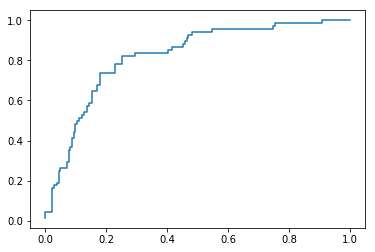

In [244]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(labels_all, logits_all, pos_label=1)
plt.plot(fpr, tpr)

In [245]:
for p in model.parameters():
    if p.requires_grad:
        print(p.size())

torch.Size([90, 50])
torch.Size([90, 30])
torch.Size([90])
torch.Size([90])
torch.Size([90, 50])
torch.Size([90, 30])
torch.Size([90])
torch.Size([90])
torch.Size([90, 60])
torch.Size([90, 30])
torch.Size([90])
torch.Size([90])
torch.Size([1, 30])
torch.Size([1])
